In [1]:
"""
Author : ’Marwa Samy
Date   : Jan 2025
Purpose : Calculating and plotting SPI-12.
"""
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import py4utilities as p4u
#import py4met as p4m
import cartopy.crs as ccrs
#import os 
import pandas as pd

import geopandas as gpd
import regionmask

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.ops import transform 
import pyproj
from shapely import wkt

In [3]:
import warnings
warnings.filterwarnings('ignore')
from shapely.geometry import mapping

<Axes: >

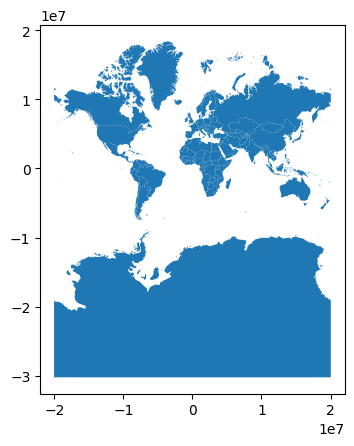

In [4]:
#%% opening the dataset
plt.close('all')
#diri='/disk2/climate/data_center/Reanalysis/ERA-5_land/'
#diri_output = '/disk2/climate/output/'

shp_file =gpd.read_file('../shapeFileWholeWorld/World_Countries_Generalized.shp')
shp_region=regionmask.Regions(shp_file.geometry)
shp_file.plot()

In [26]:
def changeProjection(shape):
    reprojection = pyproj.Transformer.from_proj(3857 , 4326, always_xy=True)
    for i in shape.index:
        reprojected_geometry = transform(reprojection.transform, shape.loc[i, 'geometry']) 
        shape.at[i, 'new_geo'] = reprojected_geometry
    return(shape)

In [22]:
def plotShapeFile(Shape, ax):
       
    for i in Shape.new_geo:
        p = gpd.GeoSeries(i)
        p.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

## Select areas

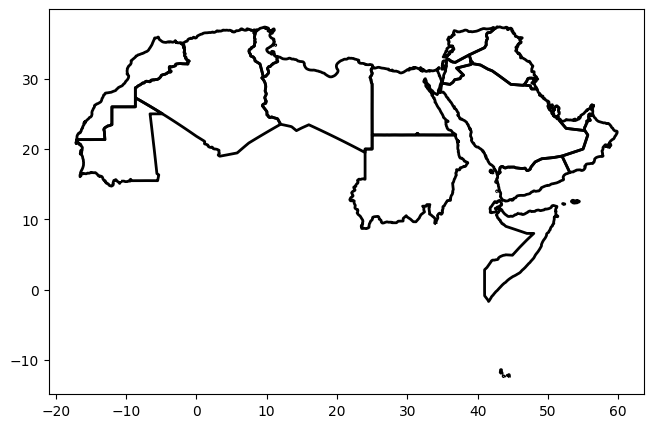

In [27]:
myShapeFile = shp_file.where(shp_file['COUNTRY'].isin(['Egypt', 'Sudan', 'Libya', 'Algeria', 'Tunisia', 'Morocco', 'Mauritania', 'Bahrain',
                                                       'Comoros', 'Djibouti', 'Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Palestinian Territory',
                                                       'Qatar', 'Saudi Arabia', 'Somalia', 'Syria', 'United Arab Emirates', 'Yemen']) )
newShape = myShapeFile.dropna()
newShape.reset_index(inplace=True)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
newShape = changeProjection(newShape)
plotShapeFile(newShape, ax)

In [8]:
EastAfrica = shp_file.where(shp_file['COUNTRY'].isin(['Sudan', 'Comoros', 'Djibouti', 'Somalia']) )
newShapeEastAfrica = EastAfrica.dropna()
newShapeEastAfrica.reset_index(inplace=True)

In [9]:
NeaarEast = shp_file.where(shp_file['COUNTRY'].isin(['Iraq', 'Syria', 'Jordan',  'Lebanon', 'Palestinian Territory']) )
newShapeNeaarEast = NeaarEast.dropna()
newShapeNeaarEast.reset_index(inplace=True)

In [10]:
NorthAfrica = shp_file.where(shp_file['COUNTRY'].isin(['Egypt', 'Libya', 'Algeria', 'Tunisia', 'Morocco', 'Mauritania']) )
newShapeNorthAfrica = myShapeFile.dropna()
newShapeNorthAfrica.reset_index(inplace=True)

In [11]:
ArabianPeninsula = shp_file.where(shp_file['COUNTRY'].isin(['Bahrain','Kuwait','Qatar', 'United Arab Emirates','Saudi Arabia','Oman','Yemen']) )
newShapeArabianPeninsula = ArabianPeninsula.dropna()
newShapeArabianPeninsula.reset_index(inplace=True)

In [12]:
regions = [newShapeNorthAfrica, newShapeEastAfrica, newShapeNeaarEast, newShapeArabianPeninsula]
regionsNames = ['North Africa', 'East Africa', 'Neaar East', 'Arabian Peninsula']

## Open File

In [41]:
ds = xr.open_dataset('Monthly_SPI-1_from_ERA5_195901-202212.nc')
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 768, latitude: 360, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 6kB 1959-01-01 1959-02-01 ... 2022-12-01
  * latitude   (latitude) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * longitude  (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    spi        (time, latitude, longitude) float64 2GB ...

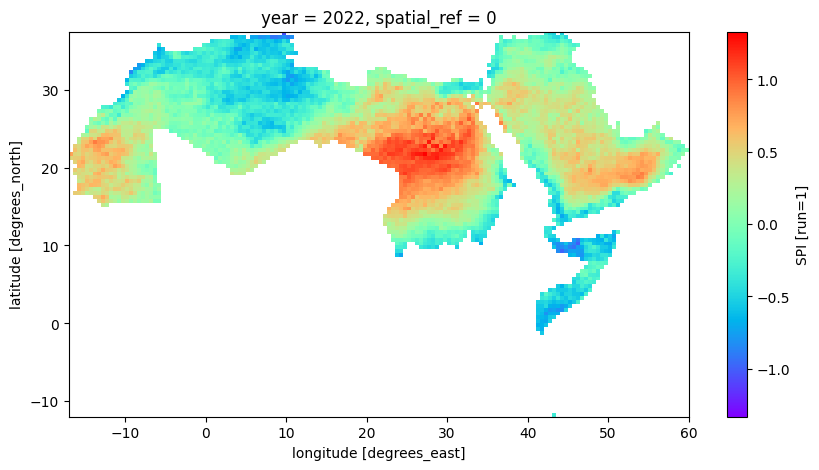

In [47]:
import rioxarray
from shapely.geometry import mapping

dsYearly = ds.spi.groupby('time.year').mean(['time'])
dsYearly = dsYearly.rio.write_crs("EPSG:4326", inplace=True)
ds_shaped = dsYearly.rio.clip(newShape.geometry.apply(mapping), newShape.crs)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ds_shaped[-1,:,:].plot(ax=ax, cmap=plt.cm.rainbow)
fig.savefig(f'SPI2022Old.jpg')

## Plot yearly mean

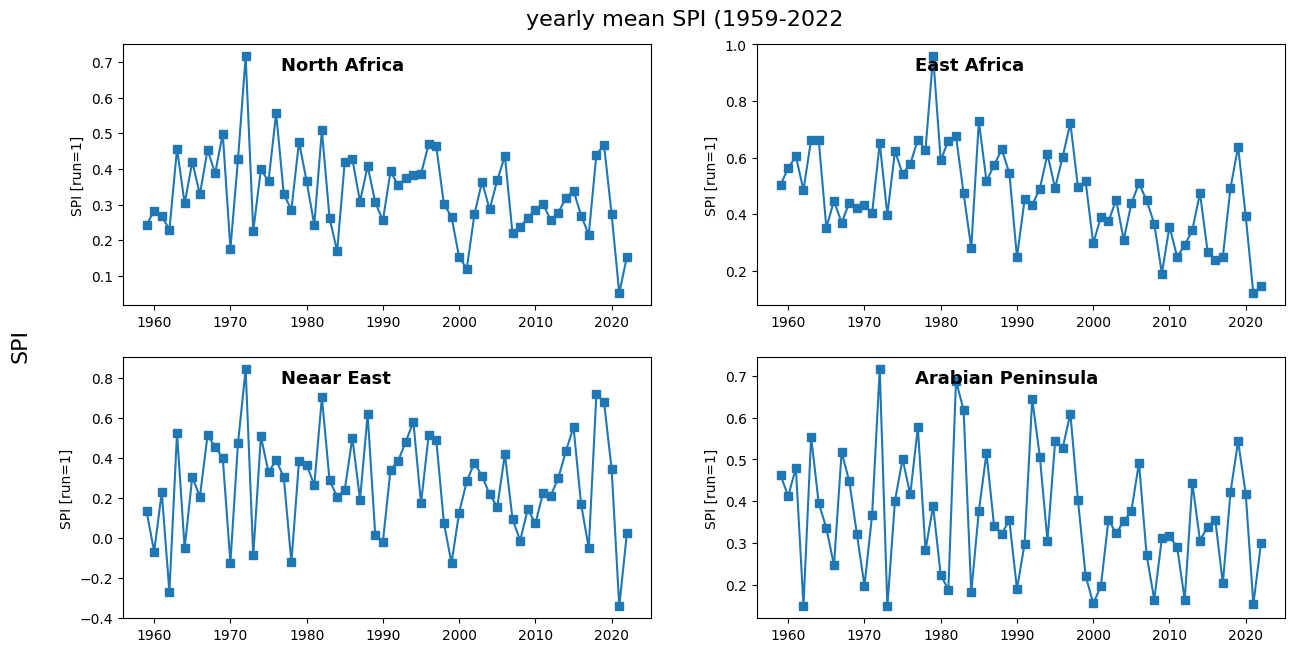

In [78]:
m=0

fig, ax = plt.subplots(2, 2, figsize=(15,7))
for i in range(2):
    for j in range(2):
        ds_shaped = ds.rio.clip(regions[m].geometry.apply(mapping), regions[m].crs)
        xs = ds_shaped.spi.groupby('time.year').mean(['time', 'longitude','latitude'])
        #xs = xs.set_index(range(1991,2020))
        xs.plot(ax=ax[i, j],  marker='s')
        ax[i, j].set_title("")
        ax[i, j].set_xlabel("")
        ax[i, j].text(0.3, 0.9, regionsNames[m], fontsize=13, weight='bold', transform = ax[i, j].transAxes)
        #ax[m-1].set_xticks(range(29))
        #ax[m-1].set_xticklabels(range(29), fontsize=9)
        m+=1

#title = f'Monthly mean temperature of {stationName[s]}'                 #**********************************
title = f'yearly mean SPI (1959-2022'
plt.suptitle(title, fontsize=16)
plt.subplots_adjust(top=0.93)

#yaxis_label = 'Temperature ( C)'                  #***************************************
yaxis_label = 'SPI'
fig.text(0.05, 0.5, yaxis_label, va='center', rotation='vertical', fontsize=16)

fig.savefig(f'yearlySPI.jpg')

## Calculate SPI from precipitation

In [13]:
dsRain = xr.open_dataset('precp1991-2024.nc') 
dsRain

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 408, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 3kB 1991-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 7kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [33]:
normal = dsRain.sel(valid_time = slice("1991-01-01", "2020-12-31"))
meanPrecep = normal.mean(['valid_time'])
stdPrecep = normal.std(['valid_time'])

dsRainYearly = dsRain.tp.groupby('valid_time.year').mean(['valid_time'])
SPI = (dsRainYearly - meanPrecep) / stdPrecep
SPI

<xarray.Dataset> Size: 141MB
Dimensions:    (latitude: 721, longitude: 1440, year: 34)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * year       (year) int64 272B 1991 1992 1993 1994 ... 2021 2022 2023 2024
Data variables:
    tp         (year, latitude, longitude) float32 141MB 0.1578 ... 0.4571

In [38]:
SPI['longitude'] = SPI.longitude - 180

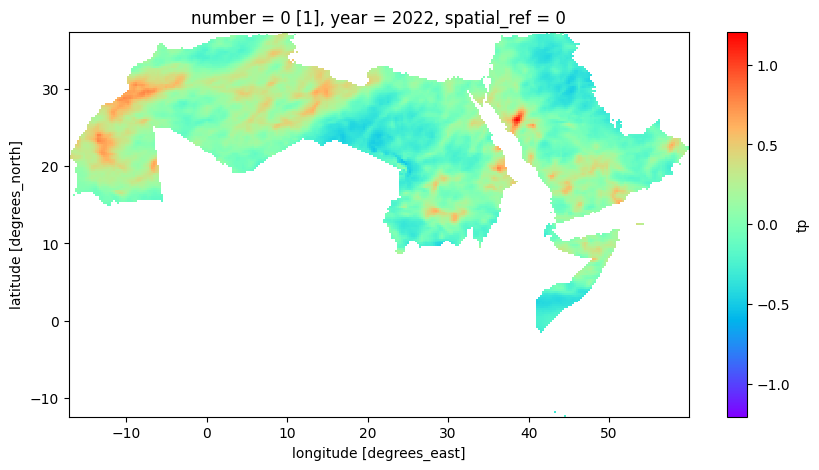

In [42]:
import rioxarray
from shapely.geometry import mapping

SPI = SPI.rio.write_crs("EPSG:4326", inplace=True)
SPI_shaped = SPI.rio.clip(newShape.geometry.apply(mapping), newShape.crs)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

SPI_shaped.tp[-3,:,:].plot(ax=ax, cmap=plt.cm.rainbow)
fig.savefig(f'SPI2022.jpg')

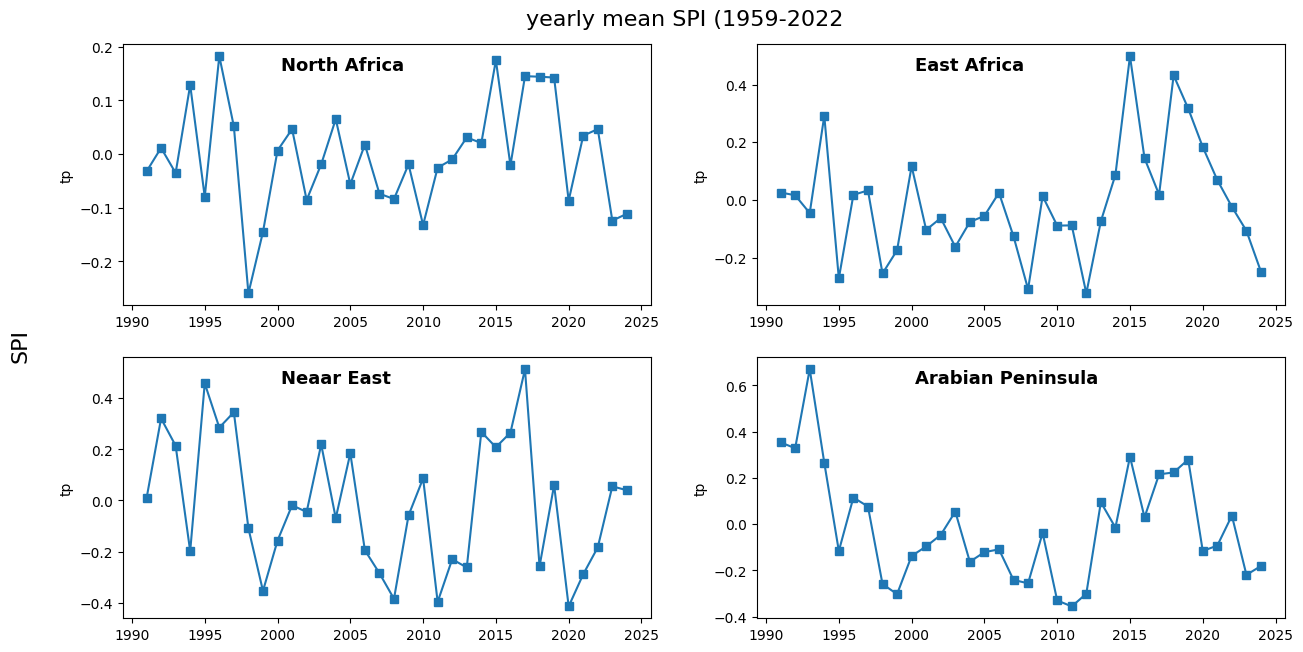

In [50]:
m=0

fig, ax = plt.subplots(2, 2, figsize=(15,7))
for i in range(2):
    for j in range(2):
        ds_shaped = SPI.rio.clip(regions[m].geometry.apply(mapping), regions[m].crs)
        xs = ds_shaped.tp.mean(['longitude','latitude'])
        #xs = xs.set_index(range(1991,2020))
        xs.plot(ax=ax[i, j],  marker='s')
        ax[i, j].set_title("")
        ax[i, j].set_xlabel("")
        ax[i, j].text(0.3, 0.9, regionsNames[m], fontsize=13, weight='bold', transform = ax[i, j].transAxes)
        #ax[m-1].set_xticks(range(29))
        #ax[m-1].set_xticklabels(range(29), fontsize=9)
        m+=1

#title = f'Monthly mean temperature of {stationName[s]}'                 #**********************************
title = f'yearly mean SPI (1959-2022'
plt.suptitle(title, fontsize=16)
plt.subplots_adjust(top=0.93)

#yaxis_label = 'Temperature ( C)'                  #***************************************
yaxis_label = 'SPI'
fig.text(0.05, 0.5, yaxis_label, va='center', rotation='vertical', fontsize=16)

fig.savefig(f'yearlySPI.jpg')

In [49]:
SPI.tp.mean(['longitude','latitude'])


<xarray.DataArray 'tp' (year: 34)> Size: 136B
array([-0.01788617, -0.01021416, -0.02642061, -0.04352767, -0.03707698,
       -0.00803472, -0.02646204, -0.00791481, -0.02039783, -0.01830221,
       -0.009422  , -0.01280654, -0.03445129, -0.03166594, -0.00375093,
        0.00840099,  0.00014932, -0.00155424, -0.00278479,  0.01995735,
        0.02113907,  0.00512418,  0.01809292,  0.00342213,  0.03181395,
        0.04628439,  0.05033396,  0.04499715,  0.01941604,  0.04354145,
        0.00328887,  0.02900415,  0.04798274,  0.05923446], dtype=float32)
Coordinates:
    number       int64 8B 0
  * year         (year) int64 272B 1991 1992 1993 1994 ... 2021 2022 2023 2024
    spatial_ref  int32 4B 0